Implementation of ID3 Decision tree on the titanic data Set.
It is a classification algorithm that follows a greedy approach by selecting a best attribute that yields maximum Information Gain(IG) or minimum Entropy(H).

In [1]:
import pandas as pd
import numpy as np
import math

import graphviz
import pickle
from sklearn import tree
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [2]:
training_data = pd.read_csv("train.csv")
testing_data = pd.read_csv("test.csv")

In [3]:
def clean_data(the_data):
    # Drops non relevant columns
    the_data = the_data.drop(['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin', 'Embarked'], axis = 1)
    
    # Fills missing ages to the median of availables ages
    the_data["Age"] = the_data["Age"].fillna(the_data["Age"].mean())

    # Convert female and males to 0's and 1's
    the_data['Sex'] = the_data['Sex'].map({'female':0, 'male':1})

    # Toddler - 0
    # Child - 1
    # Adult - 2
    # Elderly - 3
    the_data["Age"] = pd.cut(the_data["Age"],bins=[0,2,17,65,99],labels=[0, 1, 2, 3])

    # Categorizes the number of siblings to having no siblings or one or more
    the_data["SibSp"] = pd.cut(the_data["SibSp"],bins=[-1,0,999],labels=[0,1])
    return the_data

In [4]:
training_data = clean_data(training_data)
testing_data = clean_data(testing_data)

In [5]:
def calc_entropy(column):
    
    # Compute the counts of each unique value in the column
    counts = np.bincount(column)
    # Divide by the total column length to get a probability
    probabilities = counts / len(column)
    
    # Initialize the entropy to 0
    entropy = 0
    # Loop through the probabilities, and add each one to the total entropy
    for prob in probabilities:
        if prob > 0:
            # use log from math and set base to 2
            entropy += prob * math.log(prob, 2)

    return -entropy

In [6]:
def calc_information_gain(data, split_name, target_name):
    # Calculate the original entropy
    original_entropy = calc_entropy(data[target_name])
    
    #Find the unique values in the column
    values = data[split_name].unique()

    # Create the subsets of the data by filtering data based on the unique values
    splits = []
    for value in values:
        split = data[data[split_name] == value]
        splits.append(split)
    
    # Loop through the splits and calculate the subset entropies
    to_subtract = 0
    for subset in splits:
        prob = (subset.shape[0] / data.shape[0]) 
        to_subtract += prob * calc_entropy(subset[target_name])
    
    # Return information gain
    return original_entropy - to_subtract


In [7]:
def highest_info_gain(columns):
  #Intialize an empty dictionary for information gains
  information_gains = {}
  
  #Iterate through each column name in our list
  for col in columns:
    #Find the information gain for the column
    information_gain = calc_information_gain(data, col, 'Survived')
    #Add the information gain to our dictionary using the column name as the ekey                                         
    information_gains[col] = information_gain
  
  #Return the key with the highest value
  return max(information_gains, key=information_gains.get)

In [8]:
def make_tree(max_depth, data, the_data, attributes, target_attribute_name="Survived", parent_node_class = None):
    
    # Return element if entropy is 1 (no mix with other values)
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]
    
    # Return target attribute if dataset is empty
    elif len(data) == 2:
        return np.unique(the_data[target_attribute_name])[np.argmax(np.unique(the_data[target_attribute_name],return_counts=True)[1])]
    
    # Return target feature if attribute space is empty
    elif len(attributes) == 0:
        return parent_node_class
    
    else:
    #Set the default value for this node
        parent_node_class = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name],return_counts=True)[1])]
        
        #Splits dataset
        item_values = [calc_information_gain(data,feature,target_attribute_name) for feature in attributes] 
        best_attribute_index = np.argmax(item_values)
        best_attribute = attributes[best_attribute_index]
        
        # Initialize tree
        tree = {best_attribute:{}}
        
        # Attribute with largest information gain is removed
        attributes = [i for i in attributes if i != best_attribute]
        
        for value in np.unique(data[best_attribute]):
            # stops when reached maximum depth. Returns the developed tree so far
            if max_depth == 0:
                return (tree)
            value = value
            
            # decrement maximum depth for every created tree level
            max_depth = max_depth - 1
            
            #Split the dataset through the feature with largest information gain
            sub_data = data.where(data[best_attribute] == value).dropna()
            
            #Call the ID3 algorithm for each of those sub_datasets with the new parameters
            subtree = make_tree(max_depth, sub_data,data,attributes,target_attribute_name,parent_node_class)
            
            #Add the sub tree
            tree[best_attribute][value] = subtree
            
        return(tree) 
        

In [9]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']
the_tree = make_tree(100, training_data, training_data, features)
print("The tree: \n"+str(the_tree))

The tree: 
{'Sex': {0: {'Pclass': {1.0: {'Age': {0: 0.0, 1: 1.0, 2: {'Parch': {0.0: {'SibSp': {0: 1.0, 1: 1.0}}, 1.0: 1.0, 2.0: {'SibSp': {0: 1.0, 1: 1.0}}}}}}, 2.0: {'Parch': {0.0: {'Age': {1: 1.0, 2: {'SibSp': {0: 1.0, 1: 1.0}}}}, 1.0: {'SibSp': {0: 1.0, 1: {'Age': {0: 1.0, 1: 1.0, 2: 1.0}}}}, 2.0: 1.0, 3.0: 1.0}}, 3.0: {'Parch': {0.0: {'Age': {1: {'SibSp': {0: 1.0, 1: 1.0}}, 2: {'SibSp': {0: 1.0, 1: 1.0}}}}, 1.0: {'Age': {0: {'SibSp': {0: 1.0, 1: 1.0}}, 1: {'SibSp': {0: 1.0, 1: 0.0}}, 2: {'SibSp': {0: 0.0, 1: 0.0}}}}, 2.0: {'SibSp': {0: {'Age': {0: 1.0, 1: 1.0, 2: 1.0}}, 1: {'Age': {0: 0.0, 1: 0.0, 2: 0.0}}}}, 3.0: 0.0, 4.0: 0.0, 5.0: {'SibSp': {0: 0.0, 1: 0.0}}, 6.0: 0.0}}}}, 1: {'Pclass': {1.0: {'Age': {0: 1.0, 1: 1.0, 2: {'SibSp': {0: {'Parch': {0.0: 0.0, 1.0: 0.0, 2.0: 0.0}}, 1: {'Parch': {0.0: 0.0, 1.0: 0.0, 2.0: 0.0, 4.0: 0.0}}}}, 3: {'SibSp': {0: {'Parch': {0.0: 0.0}}, 1: 0.0}}}}, 2.0: {'Age': {0: 1.0, 1: {'SibSp': {0: 0.0, 1: 1.0}}, 2: {'Parch': {0.0: {'SibSp': {0: 0.0, 1: 0

In [10]:
def predict(query,tree,default = 1):
    for key in list(query.keys()):
        if key in list(tree.keys()):
            try:
                result = tree[key][query[key]] 
            except:
                return default

            result = tree[key][query[key]]
            if isinstance(result,dict):
                return predict(query,result)

            else:
                return result

In [11]:
def test(data,tree):
    #Create new query instances by removing the target feature column and convert it to a dictionary
    queries = data.iloc[:,:].to_dict(orient = "records")
    
    #Create a empty DataFrame in whose columns the prediction of the tree are stored
    predicted = pd.DataFrame(columns=["predicted"])
    
    #Calculate the prediction accuracy
    for i in range(len(data)):
        predicted.loc[i,"predicted"] = predict(queries[i],tree,1.0) 
    return predicted

In [12]:
#Output the learned tree as object code.

# Make the titanic tree into object code
filename = './output/object_code.sav'
pickle.dump(the_tree, open(filename, 'wb'))

# Convert it back
tree_object_model = pickle.load(open(filename, 'rb'))

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

training_data2 = pd.read_csv("train.csv")
training_data2 = clean_data(training_data2)

pre_data = test(training_data,the_tree).astype(int)
result_data = training_data2['Survived'].astype(int)

confusion_matrix = confusion_matrix(result_data.values, pre_data.values)
print('Confusion Matrix: \n' +str(confusion_matrix)+'\n')
accuracy_score = accuracy_score(result_data.values, pre_data.values)
print('Accuracy Score: \n' +str(accuracy_score)+'\n')
precision_score = precision_score(result_data.values, pre_data.values)
print('Precision Score: \n' +str(precision_score)+'\n')
recall_score = recall_score(result_data.values, pre_data.values)
print('Recall Score: \n' +str(recall_score)+'\n')

Confusion Matrix: 
[[501  48]
 [104 238]]

Accuracy Score: 
0.8294051627384961

Precision Score: 
0.8321678321678322

Recall Score: 
0.695906432748538



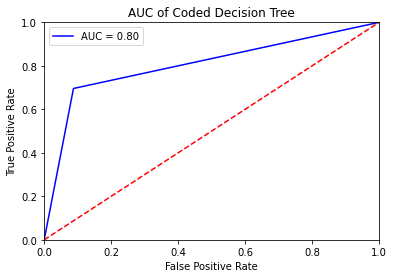

In [14]:
import scikitplot as skplt
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(result_data.values, pre_data.values)
roc_auc = metrics.auc(fpr, tpr)
plt.title('AUC of Coded Decision Tree')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'upper left')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [15]:
test_data = pd.read_csv("train.csv")
test_data = clean_data(test_data)

train_data = pd.read_csv("train.csv")
train_data = clean_data(train_data)

attributes = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']
train_attributes = train_data[attributes]
train_labels = train_data['Survived']
test_attributes = test_data[attributes]
dvec = DictVectorizer(sparse=False)
#  The fit_transform function converts the feature vector into a feature value matrix
train_attributes = dvec.fit_transform(train_attributes.to_dict(orient='records'))
print(dvec.feature_names_)

#  Decision tree model
#  Construct ID3 decision tree
clf = DecisionTreeClassifier(criterion='entropy')

#  Decision tree training
clf.fit(train_attributes, train_labels)

#  Model prediction assessment
test_attributes=dvec.transform(test_attributes.to_dict(orient='records'))

#  Decision tree forecast
pred_labels = clf.predict(test_attributes)

#  Decision tree accuracy
from sklearn.metrics import accuracy_score

train_score = clf.score(train_attributes, train_labels)
test_labels = test_data['Survived']
test_score = accuracy_score(test_labels, pred_labels)

['Age', 'Parch', 'Pclass', 'Sex', 'SibSp']


In [16]:
#  10 fold-to-confidence statistics decision tree accuracy
cv_score = np.mean(cross_val_score(clf, train_attributes, train_labels, cv=10))
print(u'Cross_val_score accuracy is: ' +str(cv_score))

Cross_val_score accuracy is: 0.7969288389513108


In [17]:
# Tree Visualization
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph.view('titanic')

'titanic.pdf'

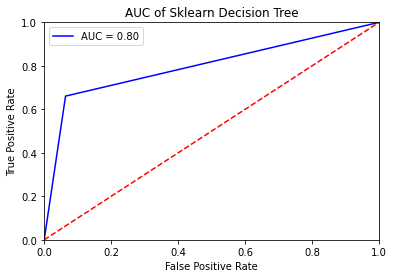

In [18]:
fpr, tpr, threshold = metrics.roc_curve(test_labels, pred_labels)
roc_auc = metrics.auc(fpr, tpr)
plt.title('AUC of Sklearn Decision Tree')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'upper left')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()